# Welcome to my IND320 Jupyter notebook

## Introduction
In this notebook, I work with the dataset `open-meteo-subset.csv` in order to explore different visualization methods. 
The objectives are:
- Read and print the dataset
- Plot each column separately
- Plot all columns together in a meaningful way
- Prepare for the Streamlit app

## Reading the supplied CSV file using Pandas and printing its contents in a relevant way.

In [14]:
# --- Imports and data loading ---
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px  # suggested interactive library
import os

# Load the dataset
df = pd.read_csv("../data/open-meteo-subset.csv")
df["time"] = pd.to_datetime(df["time"])  # ensure 'time' is datetime

# Quick preview
df.head()


time  temperature_2m (°C)  precipitation (mm)  \
0 2020-01-01 00:00:00                 -2.2                 0.1   
1 2020-01-01 01:00:00                 -2.2                 0.0   
2 2020-01-01 02:00:00                 -2.3                 0.0   
3 2020-01-01 03:00:00                 -2.3                 0.0   
4 2020-01-01 04:00:00                 -2.7                 0.0   

   wind_speed_10m (m/s)  wind_gusts_10m (m/s)  wind_direction_10m (°)  
0                   9.6                  21.3                     284  
1                  10.6                  23.0                     282  
2                  11.0                  23.5                     284  
3                  10.6                  23.3                     284  
4                  10.6                  22.8                     284

### I showed here all the columns

In [15]:
for i, col in enumerate(df.columns):
    print(f"{i}: {col}")

0: time
1: temperature_2m (°C)
2: precipitation (mm)
3: wind_speed_10m (m/s)
4: wind_gusts_10m (m/s)
5: wind_direction_10m (°)


## I plot each column separately.

In [16]:
import plotly.express as px

for col in df.columns[1:]:
    fig = px.line(df, x="time", y=col, title=col)
    fig.update_xaxes(title="Date", dtick="M1", tickformat="%b %d")
    fig.update_layout(showlegend=False)
    fig.show()


# 

## Ploting all columns together. 

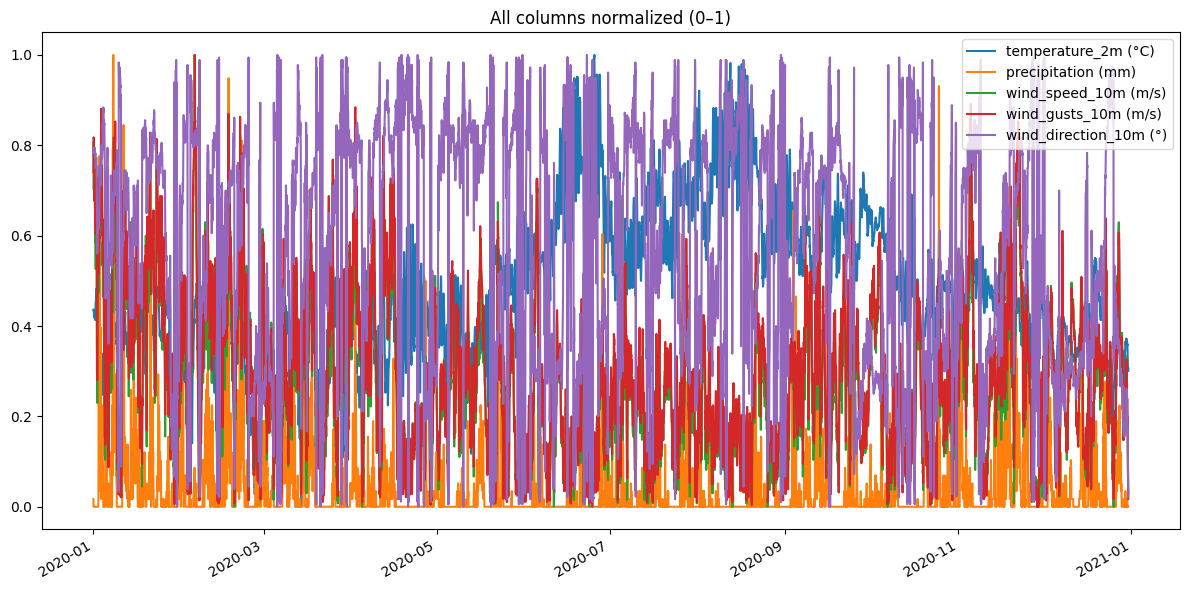

In [17]:
from sklearn.preprocessing import MinMaxScaler

# Convert 'time' to datetime for better handling of the x-axis
df["time"] = pd.to_datetime(df["time"])

# Normalize all columns (except time) so that variables with different units (°C, mm, m/s, °) 
# can be plotted together on the same scale (0–1). 
# This allows comparing trends rather than absolute values.
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df.iloc[:, 1:])
scaled_df = pd.DataFrame(scaled, columns=df.columns[1:])
scaled_df["time"] = df["time"]

# Plot all normalized columns
plt.figure(figsize=(12, 6))
for col in scaled_df.columns[:-1]:
    plt.plot(scaled_df["time"], scaled_df[col], label=col)

plt.gcf().autofmt_xdate()  # auto-format x-axis labels for dates
plt.legend()
plt.title("All columns normalized (0–1)")
plt.tight_layout()
plt.show()


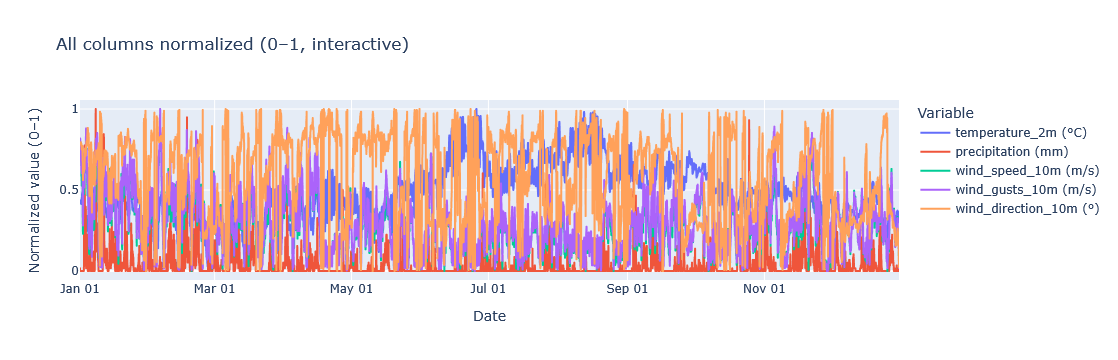

In [18]:
import plotly.express as px

# Melt data for plotly (long format)
melted = scaled_df.melt(id_vars="time", var_name="Variable", value_name="Normalized value")

fig = px.line(
    melted,
    x="time",
    y="Normalized value",
    color="Variable",
    title="All columns normalized (0–1, interactive)",
)
fig.update_xaxes(title="Date", tickformat="%b %d")
fig.update_yaxes(title="Normalized value (0–1)")
fig.update_layout(legend_title_text="Variable")
fig.show()


## Observation
When plotting all columns together over the entire time period, the figure becomes overcrowded and difficult to interpret. Although normalization puts the variables on the same scale (0–1), the large number of data points and the different dynamics of each variable make the plot unreadable.

Therefore, it is useful to consider alternative visualizations that preserve the idea of showing all variables together but in a more interpretable way. Examples include:

Focusing on a shorter time window (e.g., one month instead of the full year) to reduce clutter and highlight short-term relationships.

Applying smoothing (rolling averages) to reduce noise and reveal clearer trends.

Using correlation plots to summarize relationships numerically rather than plotting every single data point.

These approaches make it possible to compare variables "together" while also providing insights that are not visible in the raw, overcrowded plot.

## Correlation matrix

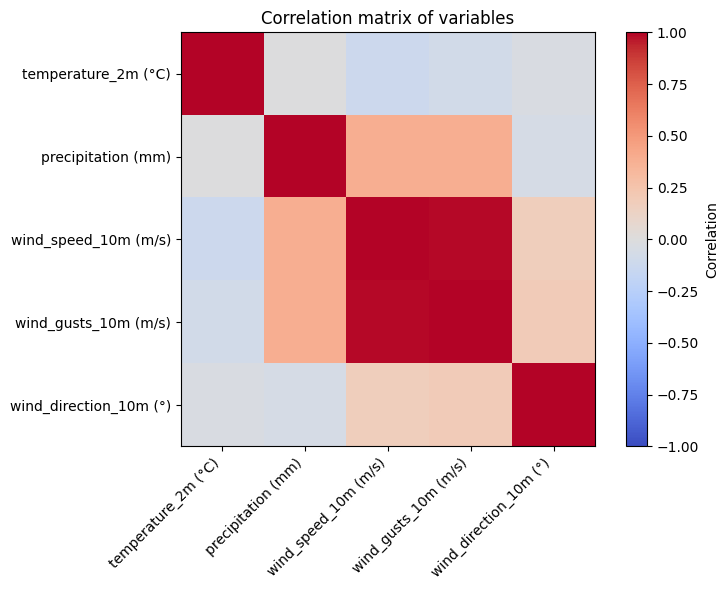

In [19]:
corr = df.drop(columns="time").corr()

plt.figure(figsize=(8,6))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation matrix of variables")
plt.tight_layout()
plt.show()


## Observation 
The correlation matrix shows that wind speed and wind gusts are almost perfectly correlated, which is expected as gusts are short-term peaks of wind speed. Precipitation is moderately correlated with both wind speed and gusts, suggesting that windy conditions often come with rain. Temperature, however, shows almost no linear correlation with the other variables, and wind direction appears largely independent of the other measurements.

## Focusing on a shorter time window

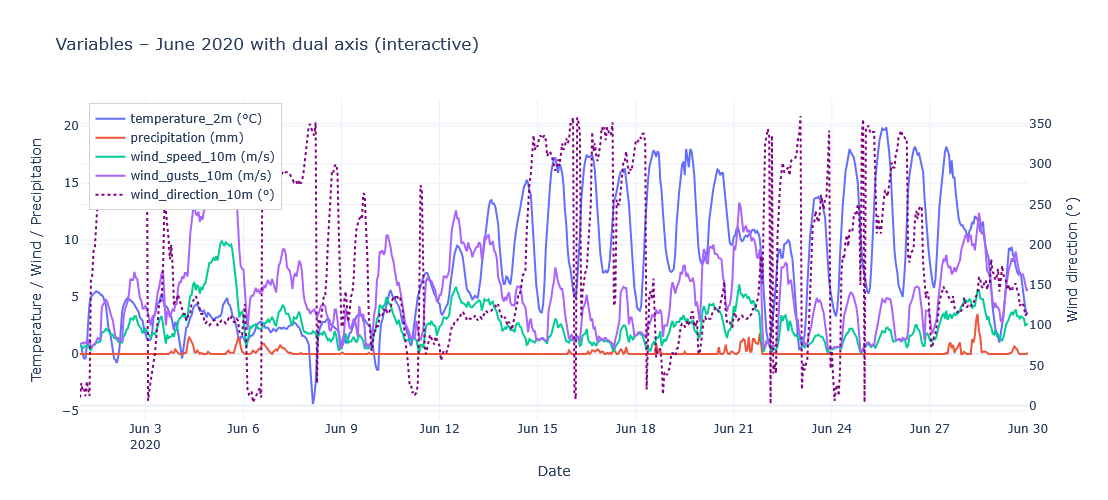

In [21]:
import plotly.graph_objects as go

# Define subset again
subset = df[(df["time"] >= "2020-06-01") & (df["time"] <= "2020-06-30")]

fig = go.Figure()

# Add main variables (left y-axis)
for col in subset.columns[1:-1]:
    fig.add_trace(go.Scatter(
        x=subset["time"],
        y=subset[col],
        mode='lines',
        name=col,
        yaxis="y1"
    ))

# Add wind direction (right y-axis)
fig.add_trace(go.Scatter(
    x=subset["time"],
    y=subset["wind_direction_10m (°)"],
    mode='lines',
    name='wind_direction_10m (°)',
    line=dict(color='purple', dash='dot'),
    yaxis="y2"
))

# Layout
fig.update_layout(
    title="Variables – June 2020 with dual axis (interactive)",
    xaxis=dict(title="Date"),
    yaxis=dict(title="Temperature / Wind / Precipitation"),
    yaxis2=dict(title="Wind direction (°)", overlaying='y', side='right'),
    legend=dict(x=0.01, y=0.99, bordercolor="LightGray", borderwidth=1),
    template="plotly_white",
    width=1000,
    height=500
)

fig.show()


## Project Log – IND320: Data to Decision

This first part of the IND320 project focused on learning how to handle a dataset in Jupyter Notebook, visualize it in different ways, and prepare for the Streamlit application.

I started by importing the supplied CSV file using pandas. The dataset contained several columns: time, temperature, precipitation, wind speed, wind gusts, and wind direction. At first, I printed the contents of the DataFrame to verify the data was loaded correctly. Then, I generated individual plots for each variable. For continuous variables like temperature and wind speed, line plots were most suitable, while for precipitation I tested bar plots since rainfall is often represented as discrete events.

The next challenge was plotting all columns together. Because the variables have different scales and units, the raw combined plot was unreadable. I tried two different strategies: (1) normalization of all values between 0 and 1 to compare trends, and (2) using a dual axis for wind direction so that the other variables were still visible in their original units. Both approaches improved readability, and this process taught me the importance of choosing the right visualization depending on the question I want to answer.

Additionally, I experimented with correlation matrices to explore linear relationships between variables. As expected, wind speed and wind gusts showed very strong correlation, while temperature had little direct relationship with other variables. This confirmed that some visualizations are better at highlighting patterns that are hidden in raw plots.

Regarding the use of AI, I worked with GitHub Copilot in VS Code and ChatGPT to support my coding and documentation. Copilot helped me quickly write plotting loops and boilerplate code, while ChatGPT was useful for explaining why some visualization choices (e.g., normalization vs. multiple axes) are more appropriate than others. The AI tools did not replace my work but accelerated my understanding and gave me alternative approaches when I was stuck. For example, I would not have thought about applying rolling averages or correlation matrices without this guidance.

So far, I have learned how to structure my notebook with clear headings, comment code properly, and export results. The next step is to integrate these insights into a Streamlit application that will allow interactive exploration of the data.

**GitHub Repository:** [https://github.com/JulesSylMUAMBA/IND320_DataTo_Decision](https://github.com/JulesSylMUAMBA/IND320_DataTo_Decision)  
**Streamlit App:** [https://ind320datatodecision-fnmdxfu8zeflxwwdgdjvmx.streamlit.app/)
